In [1]:
library(Seurat)
library(dplyr)
library(tibble)
library(viridis)
library(ComplexHeatmap)
library(circlize)
library(ggplot2)
source("./dis.fun.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, plea

In [2]:
###-----------------------------------------------------------------------------
## Defined by DV RGC progression [using the raw data]

## Extract AUC matrix
auc <- readRDS(file = paste0("./load_files/", "AUCell_RGC_pseudobulk_modulescore_auc_res.rds")) %>%
            as.data.frame(., check.names = FALSE)
rgc_cls <- c("NESC RSPO3 DIRAS3", "NESC RSPO3 TEX15", "vRG HMGA2 CCND1", "RGC FABP7 PMP22", 
             "vRG SAT1 STMN2", "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal FOXJ1", 
             "oRG HOPX TNC", "oRG HOPX APOE", "GE RG HMGA2 NKX6-2", 
             "GE RG HMGA2 NR2F2", "GE RG STMN2 SOX5", "GE RG CRYAB", 
             "GE Ependymal FOXJ1", "GE RG HOPX STMN1", "GE RG HOPX NRG1")
mat <- as.matrix(auc) %>% 
            scale() %>% t() %>%
            MinMax(., min = -1.5, max = 1.5)
knot_ord <- lapply(rgc_cls, function(x) paste0(x, "_", 1:100)) %>%
            unlist() %>%
            unique()
mat <- mat[, knot_ord]
                   
                   
## order gene list based on their peak of the mean AUC scores
meanauc <- aggregate(x = auc, by = list(subtype = 
                                        setNames(extract_field(rownames(auc), 1, "_"), NULL)), FUN = mean) %>%
            column_to_rownames("subtype") %>%
            as.matrix() %>% 
            scale()
new_order <- colnames(meanauc)[order(apply(meanauc[rgc_cls, ], 2, function(x) which(x == max(x))))]



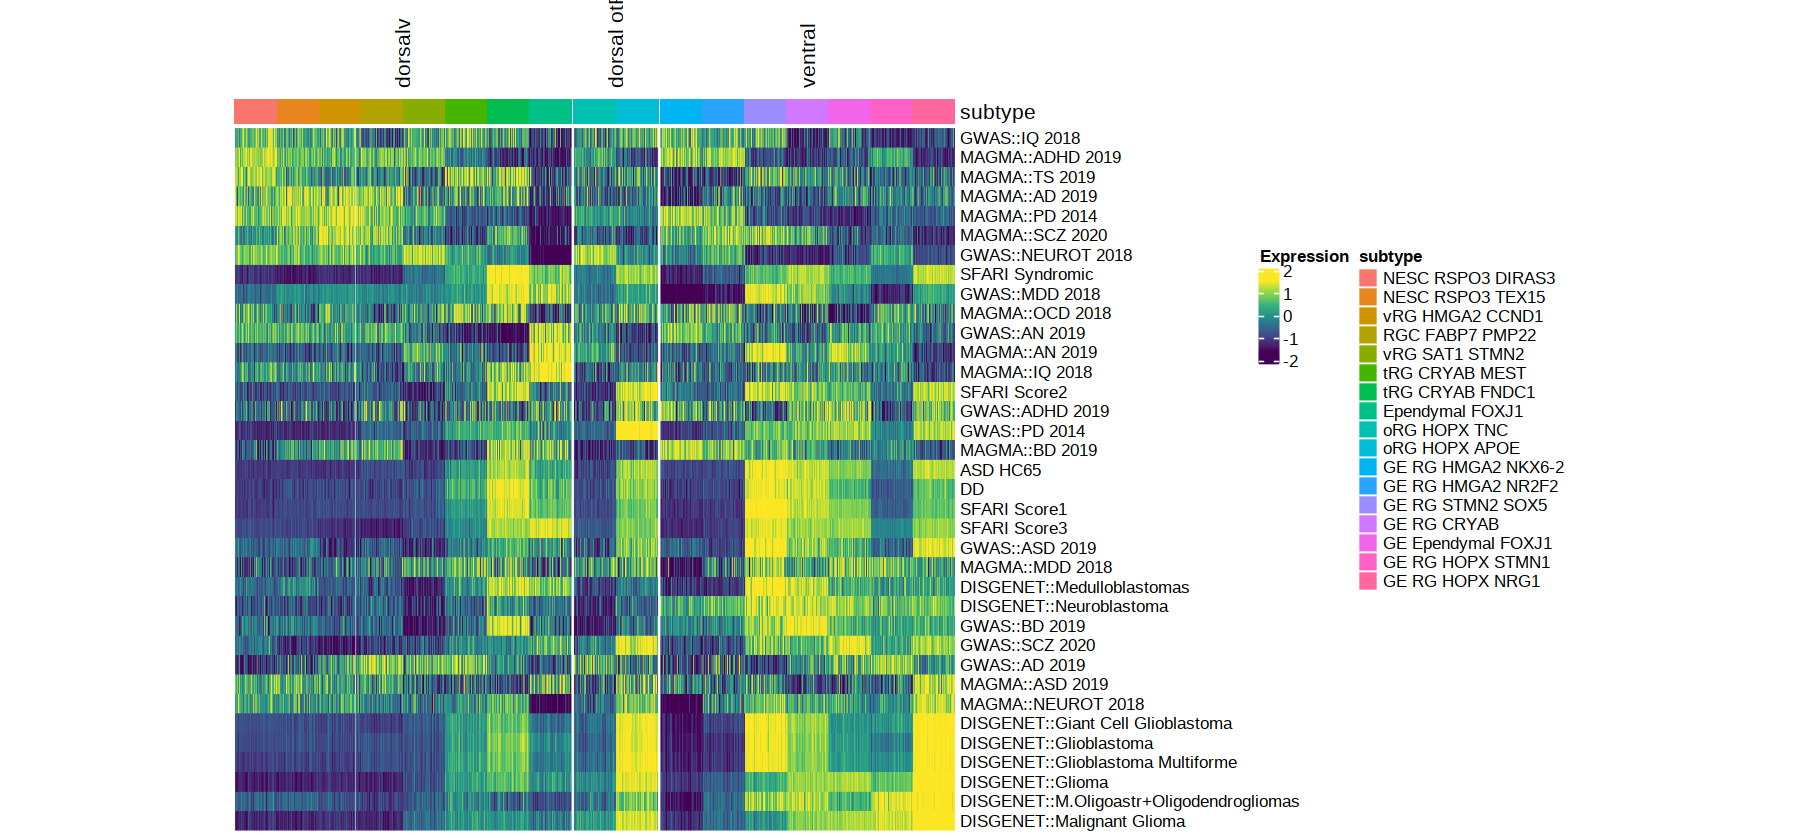

In [3]:
## Heatmap annotation
color_breaks <- seq(-1.5, 1.5, 0.5)
col_fun1 = colorRamp2(color_breaks, viridis(length(color_breaks)))
heat_meta <- data.frame(knot = colnames(mat), stringsAsFactors = FALSE) %>%
            mutate(subtype = extract_field(knot, 1, "_")) %>%
            mutate(subtype = factor(subtype, levels = rgc_cls)) %>%
            column_to_rownames("knot") %>%
            as.data.frame()
col_split <- ifelse(grepl("^GE ", colnames(mat)), "ventral", "dorsalv")
col_split[grepl("oRG", colnames(mat)) & (!grepl("^GE ", colnames(mat)))] <- "dorsal otRG"


cols <- gg_color_hue(length(rgc_cls)) %>% 
                setNames(., rgc_cls)
column_ha <- HeatmapAnnotation(df = heat_meta, col = list(subtype = cols), name = "ii")
htlist <- Heatmap(mat[new_order, ], name = "Expression", 
        column_split = factor(col_split, levels = c("dorsalv", "dorsal otRG", "ventral")), 
        cluster_columns = FALSE,
        top_annotation = column_ha, 
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        cluster_row_slices = FALSE,
        column_title_gp = gpar(fontsize = 12),
        row_title_gp = gpar(fontsize = 0),
        column_gap = unit(0.5, "mm"),
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        col = col_fun1,
        row_names_gp = gpar(fontsize = 10),
        column_title_rot = 90,
        show_column_names = FALSE,
        show_row_names = TRUE,
        use_raster = TRUE,
        raster_quality = 4, 
        width = unit(6, "in"))
##pdf(paste0("./report/", "Expr_enrich_pseudobulkAVG_RGCs_full_ordered_DV.pdf"), width = 14, height = 6)
options(repr.plot.width=15, repr.plot.height=7)
draw(htlist)
##dev.off()

In [4]:
## Load the AUC results using the subset data
auc_subset <- readRDS(file = paste0("./load_files/", "AUCell_RGC_pseudobulk_subset_modulescore_auc_res.rds")) %>%
            as.data.frame(., check.names = FALSE)
mat_subset <- as.matrix(auc_subset) %>% 
            scale() %>% t() %>%
            MinMax(., min = -1.5, max = 1.5)
mat_subset <- mat_subset[new_order, knot_ord]


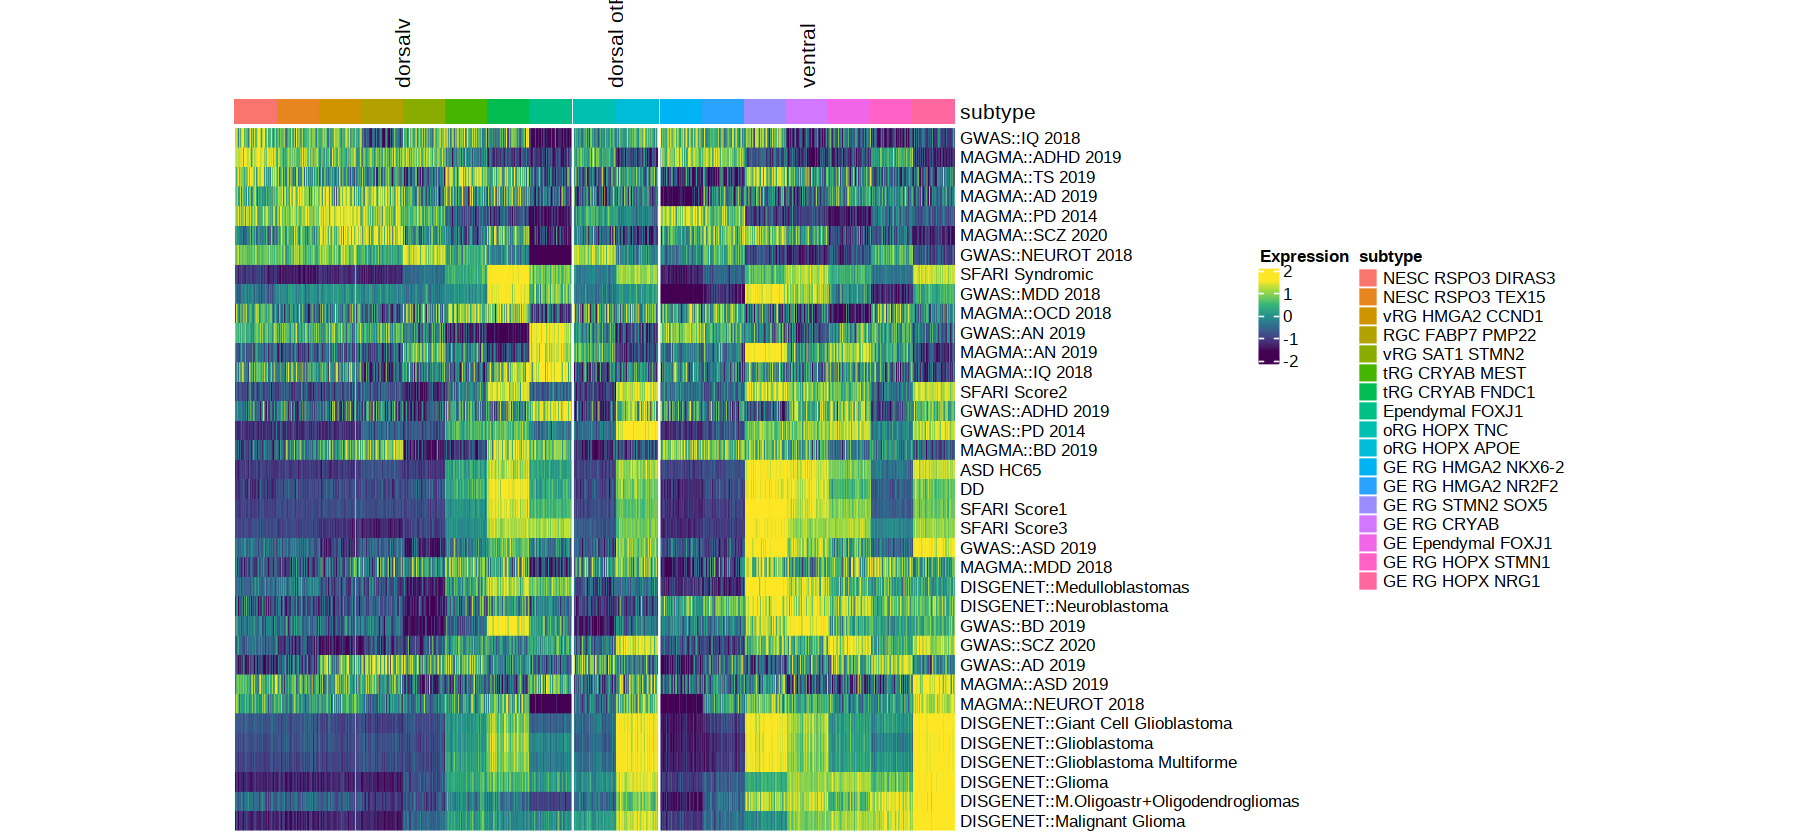

In [5]:
htlist <- Heatmap(mat_subset, name = "Expression", 
        column_split = factor(col_split, levels = c("dorsalv", "dorsal otRG", "ventral")), 
        cluster_columns = FALSE,
        top_annotation = column_ha, 
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        cluster_row_slices = FALSE,
        column_title_gp = gpar(fontsize = 12),
        row_title_gp = gpar(fontsize = 0),
        column_gap = unit(0.5, "mm"),
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        col = col_fun1,
        row_names_gp = gpar(fontsize = 10),
        column_title_rot = 90,
        show_column_names = FALSE,
        show_row_names = TRUE,
        use_raster = TRUE,
        raster_quality = 4, 
        width = unit(6, "in"))
options(repr.plot.width=15, repr.plot.height=7)
##pdf(paste0(outputdir, "Expr_enrich_pseudobulkAVG_subset_RGCs_full_ordered_DV.pdf"), width = 14, height = 6)
draw(htlist)
##dev.off()

In [6]:
## Correlate gene expression with the AUC patterns
avgs <- readRDS(file = paste0("./load_files/", "RGC_pseudobulk_avgs_v2.rds")) %>%
            as.matrix()
auc <- readRDS(file = paste0("./load_files/", "AUCell_RGC_pseudobulk_modulescore_auc_res.rds")) %>%
            as.matrix()
max_avg <- apply(avgs, 1, function(x) sum(x >= 0.25) > 3)


load("./load_files/Disease_genes_v3.Rdata") ## alltb, alllist
alllist <- lapply(alllist, function(x) intersect(x, rownames(avgs)))


topgenes <- lapply(names(alllist), function(gset) {
        genes <- alllist[[gset]]
        sub_max <- max_avg[genes]
        res <- cor(t(avgs[genes, ,drop = FALSE]), auc[, gset, drop = FALSE], method = "p")
        topg <- rownames(res)[res >= 0.7 & sub_max == 1]
        topg <- topg[order(res[topg, 1], decreasing = TRUE)]
        return(topg)
        }) %>%
        setNames(., names(alllist))
topgenes <- topgenes[sapply(topgenes, length) > 0]
topgenes

Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gset, drop = FALSE], :
“the standard deviation is zero”
Warning message in cor(t(avgs[genes, , drop = FALSE]), auc[, gse

$`ASD HC65`
[1] "NRXN1"  "ANK2"   "ASH1L"  "TRIP12" "KMT2C"  "WDFY3"  "TNRC6B" "NCKAP1"

$DD
 [1] "NFIX"    "SMARCA2" "DYNC1H1" "KAT6A"   "TCF4"    "PTPN11"  "NSD1"   
 [8] "KAT6B"   "KMT2A"   "CDKL5"   "ZBTB18" 

$`SFARI Score1`
 [1] "NRXN1"   "ASH1L"   "MED13"   "TRIP12"  "PHF3"    "ANK2"    "ATRX"   
 [8] "SMARCA2" "KMT5B"   "KMT2C"   "PTPN11"  "TCF4"    "DYNC1H1" "TAOK1"  
[15] "TANC2"   "AHDC1"   "NF1"     "SETD2"   "NSD1"    "GRIA2"   "CDKL5"  
[22] "EP300"   "VPS13B"  "SMARCC2" "SKI"     "KMT2A"   "SON"    

$`SFARI Score2`
[1] "SPEN"

$`SFARI Score3`
 [1] "DST"      "ARHGAP5"  "THRA"     "CASC4"    "NFIA"     "UBE2H"   
 [7] "PBX1"     "ARNT2"    "USP9Y"    "DPYSL3"   "DNER"     "PER1"    
[13] "SASH1"    "PCM1"     "ABAT"     "JMJD1C"   "SRGAP3"   "SDC2"    
[19] "BIRC6"    "MAOB"     "GTF2I"    "SLC25A27" "DMXL2"    "ARHGAP32"
[25] "MRTFB"   

$`SFARI Syndromic`
[1] "SMARCA2" "SOX6"    "NFIX"    "POU3F3"  "GATM"    "KAT6A"   "HEPACAM"
[8] "NFIB"   

$`GWAS::ASD 2019`
[1] "POU3F2" "KLC1"  

$`GWAS::MDD 2018`
[1] "TCF4"

$`GWAS::PD 2014`
[1] "SCARB2" "SYT11" 

$`GWAS::SCZ 2020`
[1] "MSI2"   "SFXN5"  "GPM6A"  "CYP7B1" "CLCN3"  "ATP2A2"

$`MAGMA::ADHD 2019`
[1] "LSM6"   "RPL8"   "UBE2D3" "TALDO1" "RPLP2" 

$`MAGMA::PD 2014`
[1] "DCTPP1" "VKORC1"

$`DISGENET::Giant Cell Glioblastoma`
[1] "GRIK2"  "NOTCH2" "APC"    "NF1"    "CTNND2" "FGFR1"  "VEGFA" 

$`DISGENET::Glioblastoma`
[1] "GRIK2"  "NOTCH2" "APC"    "NF1"    "CTNND2" "VEGFA"  "FAT1"  

$`DISGENET::Glioblastoma Multiforme`
[1] "GRIK2"  "NOTCH2" "APC"    "NF1"    "STAG2"  "CTNND2" "ATRX"   "VEGFA" 

$`DISGENET::Glioma`
[1] "QKI"     "CLCN3"   "ATP1B2"  "APC"     "FAM107A" "STAG2"   "FGFR1"  
[8] "NF1"     "ATRX"   

$`DISGENET::M.Oligoastr+Oligodendrogliomas`
[1] "NOTCH2" "FGFR1" 

$`DISGENET::Malignant Glioma`
[1] "FAM107A" "CLCN3"   "ATP1B2"  "QKI"     "FGFR1"

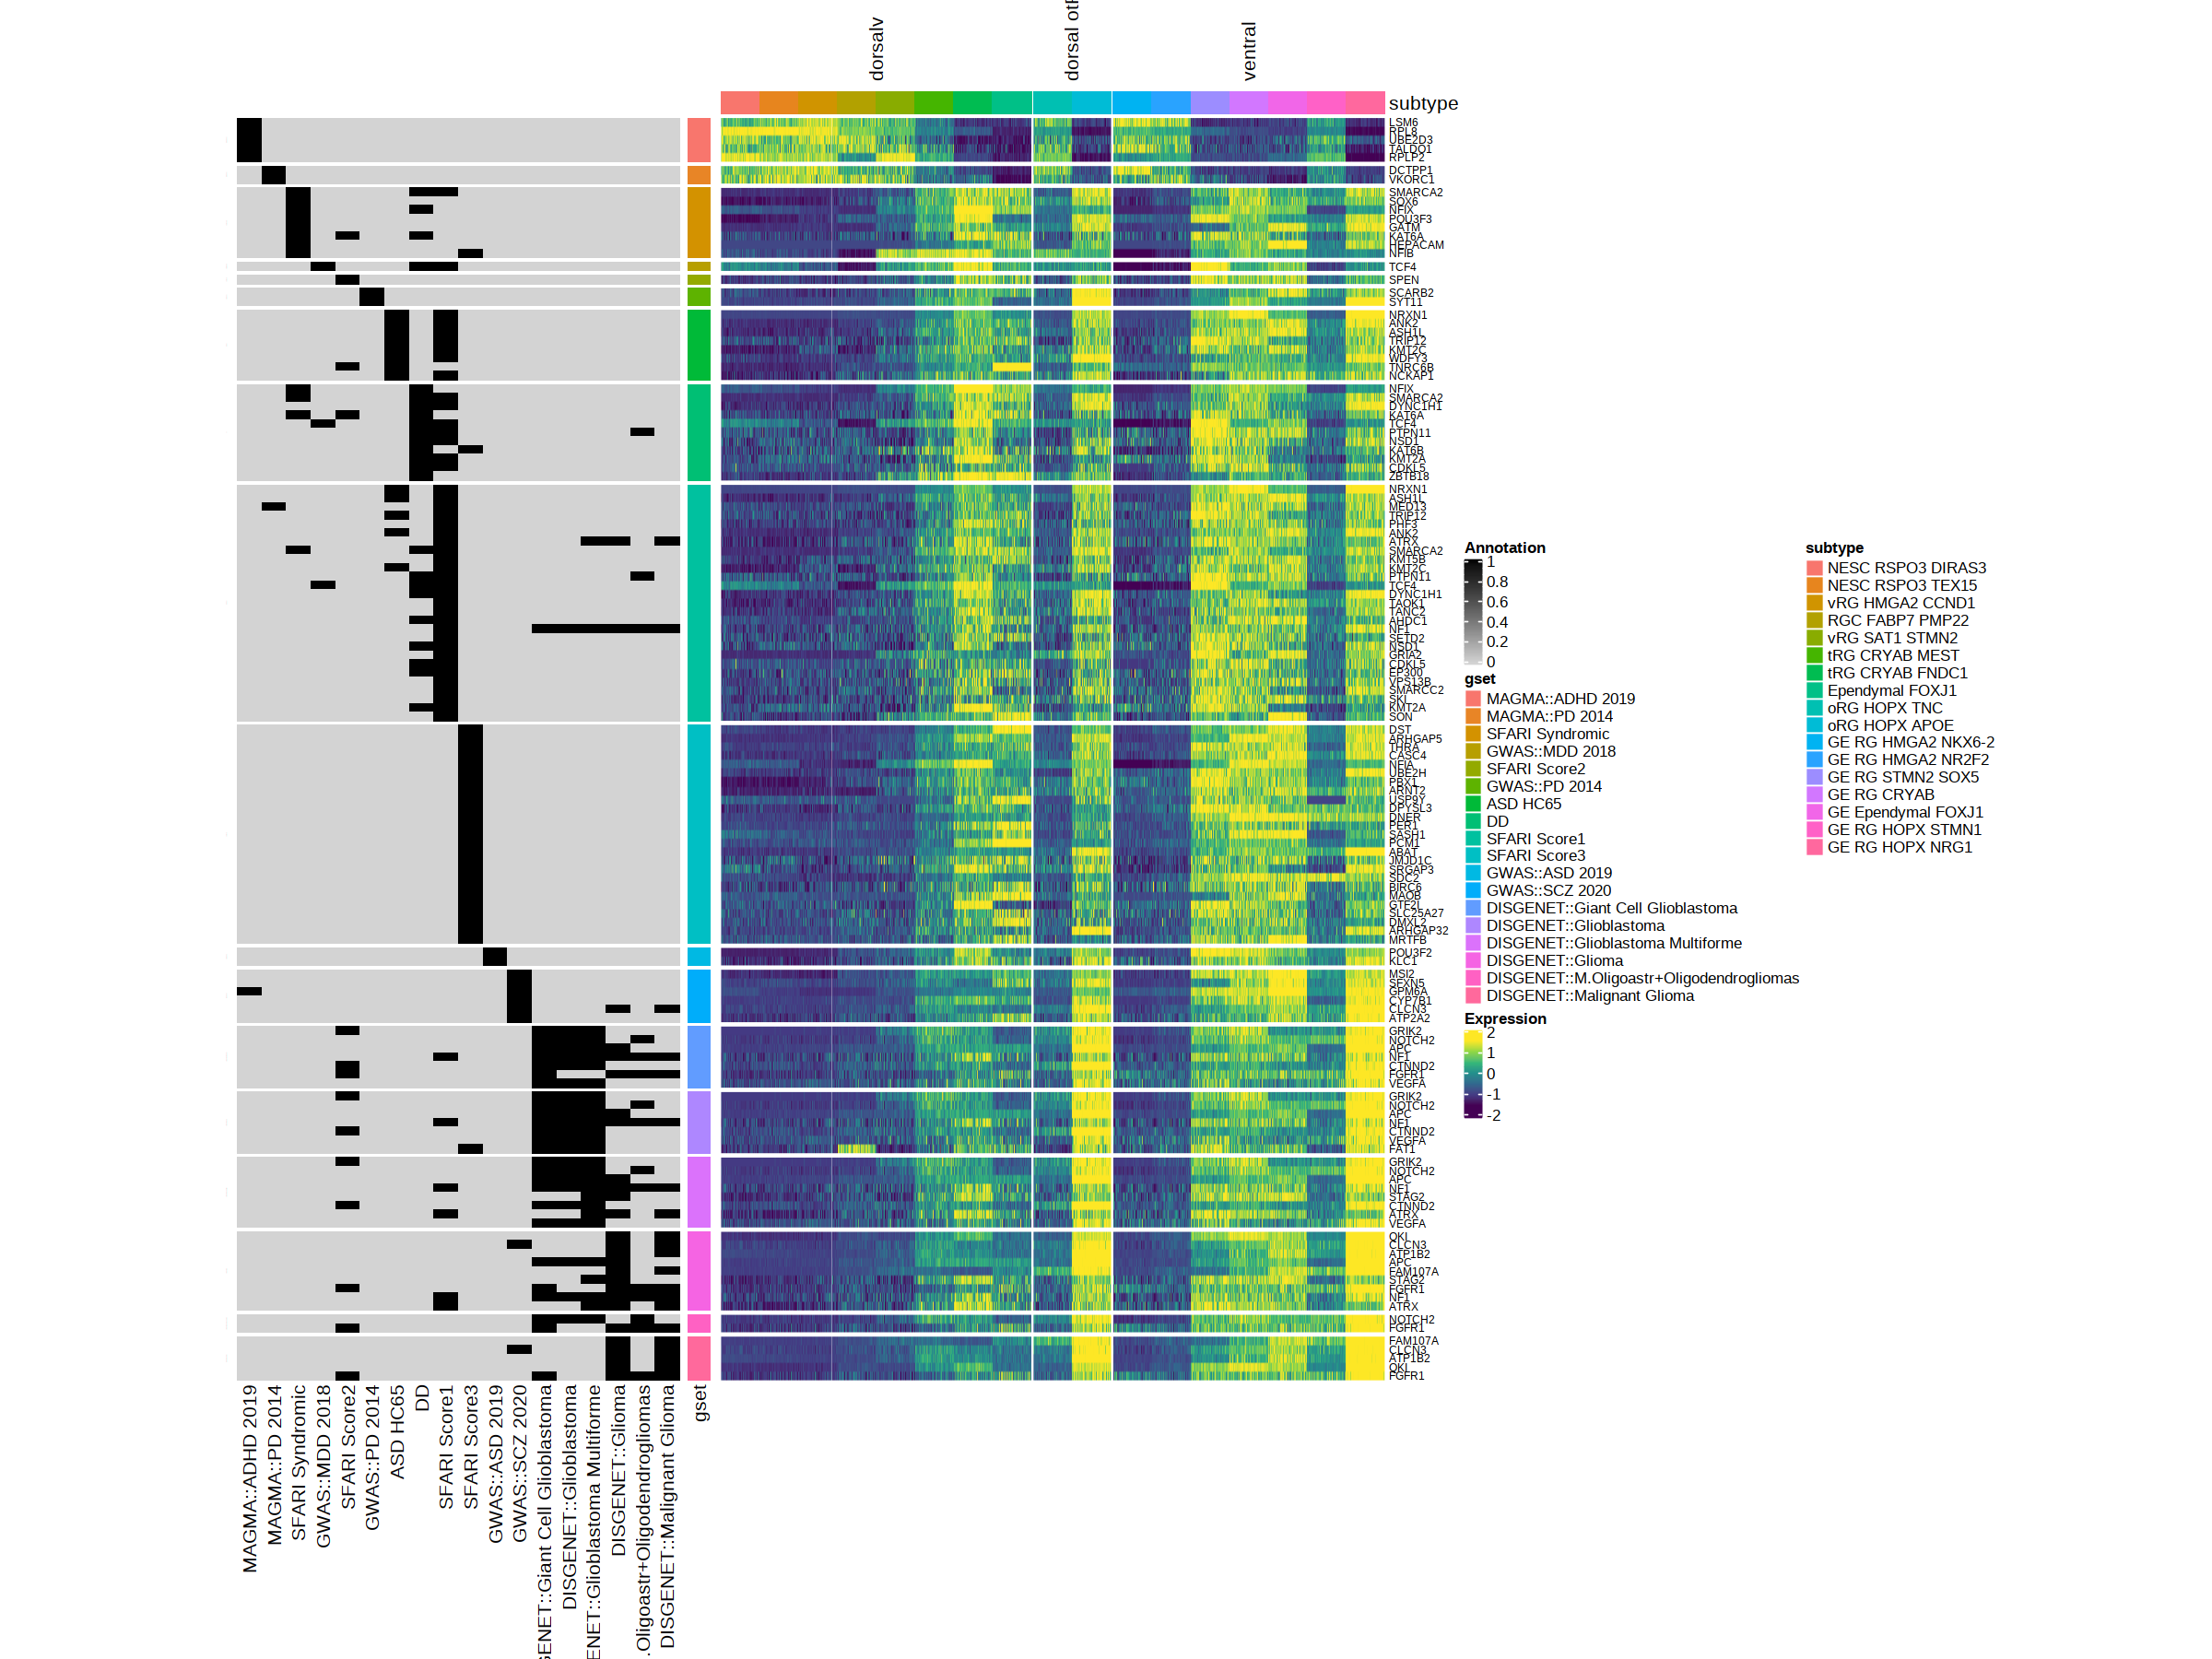

In [7]:
## For each cotegory, plot the gene separately
new_order <- intersect(new_order, names(topgenes))

## expression of the selected genes
mat_expr <- lapply(new_order, function(gset) {
    mm <- avgs[topgenes[[gset]], ,drop = FALSE] %>% 
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 1.5)
    rownames(mm) <- paste0(gset, "::", rownames(mm))
    return(mm)
    }) %>%
    do.call(rbind, .)
mat_expr <- mat_expr[, knot_ord]


## heatmap annotation
color_breaks <- seq(-1.5, 1.5, 0.5)
col_split <- ifelse(grepl("^GE ", colnames(mat_expr)), "ventral", "dorsalv")
col_split[grepl("oRG", colnames(mat_expr)) & (!grepl("^GE ", colnames(mat_expr)))] <- "dorsal otRG"
row_split <- extract_field(rownames(mat_expr), "rm_end", "::")


gmeta <- data.frame(gset = factor(extract_field(rownames(mat_expr), "rm_end", "::"), levels = new_order))
mcols <- setNames(gg_color_hue(length(new_order)), new_order)
left_heat2 <- HeatmapAnnotation(df = gmeta,
                        col = list(gset = mcols),
                        which = "row",
                        name = "gene set",
                        annotation_width = unit(0.1, "in"))


tb_cbn <- lapply(new_order, function(gset) {
        tb <- alltb[topgenes[[gset]], new_order, drop = FALSE]
        rownames(tb) <- paste0(gset, "::", rownames(tb))
        return(tb)
        }) %>%
        do.call(rbind, .)
left_heat1 <- Heatmap(tb_cbn, name = "Annotation", 
        row_split = factor(row_split, levels = new_order),
        cluster_columns = FALSE,
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        cluster_row_slices = FALSE,
        column_title_gp = gpar(fontsize = 12),
        row_title_gp = gpar(fontsize = 0),
        column_gap = unit(0.5, "mm"),
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        col = colorRamp2(c(0,1), c("lightgrey", "black")),
        row_names_gp = gpar(fontsize = 7),
        column_title_rot = 90,
        show_column_names = TRUE,
        show_row_names = FALSE,
        use_raster = FALSE,
        width = unit(4, "in"))


rownames(mat_expr) <- extract_field(rownames(mat_expr), -1, "::")
cols <- gg_color_hue(length(rgc_cls)) %>% setNames(., rgc_cls)
column_ha <- HeatmapAnnotation(df = heat_meta, col = list(subtype = cols), name = "ii")
htlist <- Heatmap(mat_expr, name = "Expression", 
        row_split = factor(row_split, levels = new_order),
        column_split = factor(col_split, levels = c("dorsalv", "dorsal otRG", "ventral")), 
        cluster_columns = FALSE,
        top_annotation = column_ha, 
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        cluster_row_slices = FALSE,
        column_title_gp = gpar(fontsize = 12),
        row_title_gp = gpar(fontsize = 0),
        column_gap = unit(0.5, "mm"),
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        col = col_fun1,
        row_names_gp = gpar(fontsize = 7),
        column_title_rot = 90,
        show_column_names = FALSE,
        show_row_names = TRUE,
        use_raster = TRUE,
        raster_quality = 4, 
        width = unit(6, "in"))
htlist <- left_heat1 + left_heat2 + htlist
##pdf(paste0("./report/", "Expr_enrich_pseudobulkAVG_RGCs_High-Cor_genes.pdf"), width = 20, height = 15)
options(repr.plot.width=20, repr.plot.height=15)
draw(htlist)
##dev.off()

`summarise()` has grouped output by 'cbnage'. You can override using the `.groups` argument.



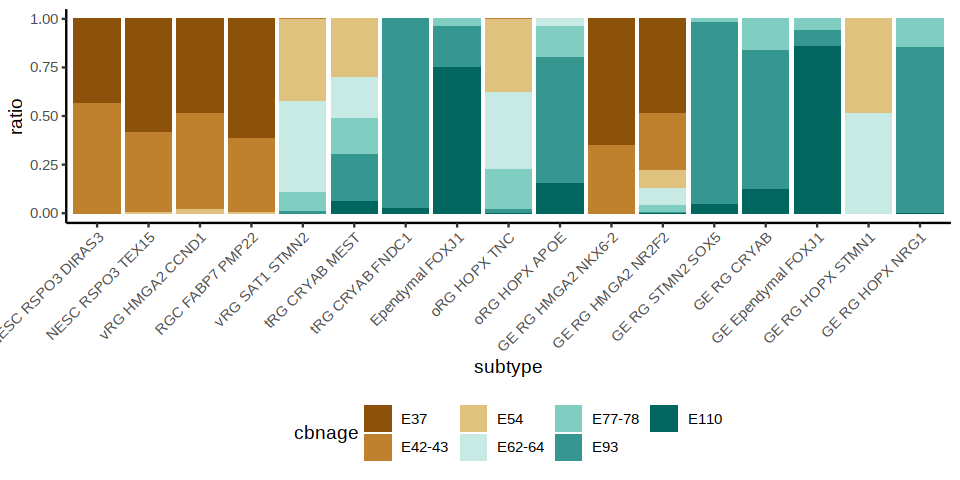

In [8]:
## Plot the meta data for the RGC subtypes
fmeta <- readRDS(file = paste0("../../MF1/overview/load_files/intermediate/Reanno_E37-110.org.meta.rds"))
fmeta$subtype <- fmeta$subtype2
rgcmeta <- fmeta[fmeta$subtype %in% rgc_cls, ]


## Plot the props
age_cols <- c("#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e") %>% 
setNames(., c("E37", "E42-43", "E54", "E62-64", "E77-78", "E93", "E110"))

pdata <- rgcmeta %>%
            group_by(cbnage, subtype, .drop = FALSE) %>%
            summarize(ncells = n()) %>%
            ungroup() %>%
            group_by(subtype) %>%
            mutate(ratio = ncells/sum(ncells)) %>%
            mutate(subtype = factor(subtype, levels = rgc_cls)) %>%
            mutate(cbnage = factor(cbnage, levels = names(age_cols)))

p <- ggplot(pdata, aes(x = subtype, y = ratio, fill = cbnage)) +
            geom_bar(position = "stack", stat = "identity") +
            scale_fill_manual(values = age_cols) +
            theme_classic() +
            RotatedAxis(legend.position = "bottom")
options(repr.plot.width=8, repr.plot.height=4)
p
##pdf(paste0("./report/", "RGC_subtype_age_prop.pdf"))
##print(p)
##dev.off()



In [9]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] AUCell_1.8.0         BiocParallel_1.20.1  foreach_1.5.0       
 [4] ggplot2_3.3.0        circlize_0.4.13      ComplexHeatmap_2.2.0
 [7] viridis_0.5.1        viridisLite_0.3